Classifying 1D Spectra with Convolutional Neural Networks (CNNs)
===



Author: Nathan A. Mahynski
    
Date: 2024/09/20
    
Description: Examples of how to classify 1D spectra and 2D "images" using explainable CNNs under "open set" conditions.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/cnn_spectral_classification.ipynb)

This work is based on [Mahynski, N.A., Sheen, D.A., Paul, R.L. et al. Encoding PGAA spectra as images for material classification with convolutional neural networks. J Radioanal Nucl Chem (2025).](https://doi.org/10.1007/s10967-025-10165-4).

In this tutorial we will classify 1D spectra using convolutional neural networks (CNNs).  We can do this directly with 1D CNNs using the 1D input, but we can also "image" the spectra to create a 2D input then use 2D CNNs to classify them.  The reason for considering the second option is that we can leverage [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to reduce the number of degrees of freedom in the 2D model despite its apparent increase in complexity.  In this approach, we rely on a pretrained CNN "base" that was part of a classifier trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) dataset.  Such a classifier is composed on a "base" of CNN layers with a "head" composed of fully-connected layer(s); the old head can be removed and replaced with a new one, while the base is "frozen".  This new model is retrained on the new data, but the only degrees of freedom in the model come from the new head.  This dramatically reduces the number of trainable parameters, e.g., from 10 million to 10 thousand. Keras' [guide](https://keras.io/guides/transfer_learning/) has more details and background on the technique.  Many pre-trained 2D bases exist so we must work with 2D images if we want to use them.

In this example, we will use the architecture illustrated below.  The base is shown in yellow and head in blue.  Enforcing explainability (by certain techniques) places restrictions on the head architecture.  Specifically, we restrict ourselves to the ["CAM" architecture](https://arxiv.org/abs/2011.08891) which is composed of a global average pooling (GAP) and a single fully-connected layer. Out-of-distribution (OOD) detection, that is, the recognition of when a test point has undegone semantic or covariate shift relative to the model's training set, can be done with different techniques.  Refer to the [Classification Under Open Set Conditions](https://pychemauth.readthedocs.io/en/latest/jupyter/api/opensetclassification.html) notebook for details, and see [pychemauth.classifier.osr module](https://pychemauth.readthedocs.io/en/latest/pychemauth.classifier.html) for code. One (DIME) is illustated at the end of this example.

<img src="https://github.com/mahynski/pychemauth/blob/develop/docs/_static/cnn.png?raw=1" style="width:700px;">

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries    

In [2]:
if 'google.colab' in str(get_ipython()):
    # On Colab, check if runtime is attached to a GPU and install a GPU version of tensorflow if available
    try:
        import subprocess, os
        subprocess.run(["nvidia-smi"]) 
    except FileNotFoundError:
        pass # No GPU is present
    else:
        !pip install tensorflow[and-cuda]==2.14.0
        os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries 

In [4]:
# Check for presence of a GPU and list, if using
import tensorflow
tensorflow.config.list_physical_devices('GPU')

In [5]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import watermark
import shap
import keras
import sklearn
import imblearn
import copy

import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from pyts.image import GramianAngularField

from pychemauth import utils
from pychemauth.datasets import make_pgaa_images, load_pgaa
from pychemauth.classifier import osr
from pychemauth.classifier.cnn import CNNFactory
from pychemauth.analysis.explain import CAM2D, color_series, bokeh_color_spectrum

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

%load_ext watermark

%load_ext autoreload
%autoreload 2

In [6]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.5.0-45-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

keras     : 2.14.0
sklearn   : 1.3.0
matplotlib: 3.7.2
json      : 2.0.9
imblearn  : 0.11.0
watermark : 2.4.3
pychemauth: 0.0.0b4
tensorflow: 2.12.0
numpy     : 1.26.4
shap      : 0.45.1



1D CNN
---

First, let's build a CNN-based classifier using the 1D spectra.

<h3>Load Data</h3>

In [7]:
# Let's look at the data over this range of bins.
valid_range=(0, 2631)

In [7]:
def build_data(challenge=False):
    # Load the dataset, clip, then renormalize
    X, y = load_pgaa(return_X_y=True)
    X = X[:, valid_range[0] : valid_range[1]]
    X = (X.T / np.sum(X, axis=1)).T
    X = np.log(np.clip(X, a_min=1.0e-7, a_max=None))

    # Also convert X into a "single channeled image" with shape (2631, 2631, 1)
    X = np.expand_dims(X, axis=-1)

    # Exclude minor components - these have < 10 observations in the dataset
    # We can keep these as a separate "challenge" set
    mask = np.array([False]*X.shape[0])
    for class_ in ['Carbon Powder', 'Phosphate Rock', 'Zircaloy']:
        mask = mask | (y == class_)
        
    if not challenge:
        return X[~mask], y[~mask]
    else:
        return X[mask], y[mask]

In [8]:
X, y = build_data(challenge=False)

# Split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y,
)

# Convert classes from strings to integers
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Record some basic properties about this revised dataset
image_size = (valid_range[1]-valid_range[0], 1)
n_classes = len(np.unique(y))

In [9]:
# Let's write the dataset to disk so we can create data iterators later on
from pychemauth.utils import write_dataset
_ = write_dataset('./1d-dataset/train', X_train, y_train, overwrite=True, augment=False)
_ = write_dataset('./1d-dataset/test', X_test, y_test, overwrite=True, augment=False)

<h3>Learning Rate Finder</h3>

Let's build a simple model using Keras, and visualize it.  Typically, the number of filters increase with depth to help "retain" information as it is progressively "averaged out" by the convolutions.

In [10]:
def make_model(image_size, n_classes, activation='relu'):
    input_ = keras.layers.Input(shape=image_size)
    conv1 = layers.Conv1D(filters=16, kernel_size=16, activation=activation, strides=8, padding='same', use_bias=True)(input_)
    pool1 = layers.MaxPool1D(2)(conv1)
    conv2 = layers.Conv1D(filters=16*8, kernel_size=8, activation=activation, strides=4, padding='same', use_bias=True)(pool1)
    pool2 = layers.MaxPool1D(2)(conv2)
    conv3 = layers.Conv1D(filters=16*8*4, kernel_size=8, activation=activation, strides=2, padding='same', use_bias=True)(pool2)
    flat = layers.Flatten()(conv3)
    output = layers.Dense(n_classes, activation='softmax')(flat)
    model = keras.Model(inputs=[input_], outputs=[output])
    
    return model

/home/nam4/anaconda3/envs/pgaa-imaging/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


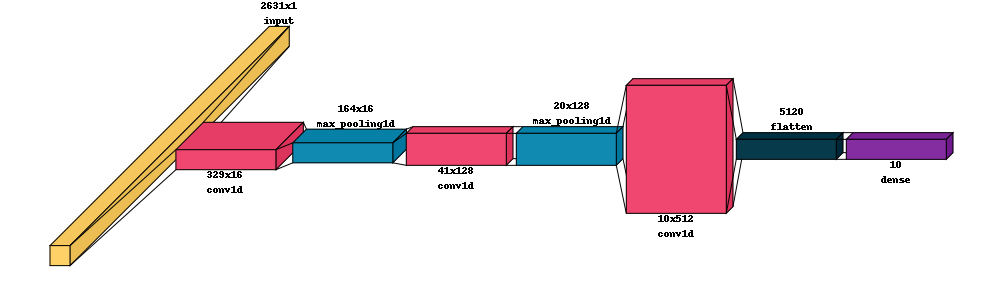

In [11]:
utils.NNTools.visualkeras(make_model(image_size, n_classes=n_classes, activation='elu'), max_z=100)

To train the model most efficiently we need to identify a learning rate for our optimizer.  Here, we will use the `learning_rate_finder` which quickly moves through a range of rates to see how the loss function responds.  At low rates the loss will not change much while at very high rates we expect this to "explode" - however, at intermediate rates we expecct to find the loss starting to decrease.  The optimal learning rate is often considered somewhere just before the minimum in this curve; sometimes it is taken as the point where the loss is changing the fastest.  We will actually use this curve to determine bounds for cyclical learning rates.  See the [original paper](https://arxiv.org/pdf/1506.01186) for more details.

In [12]:
??utils.NNTools.find_learning_rate

In [13]:
# This data loader will shuffle the data around between epochs
data_loader = utils.NNTools.build_loader('./1d-dataset/train', batch_size=100, shuffle=True)

finder = utils.NNTools.find_learning_rate(
    make_model(image_size, n_classes=n_classes, activation='elu'),
    data_loader,
    start_lr=1.0e-6,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 0s 154ms/step
Epoch 1/42
3/3 [==============================] - 1s 44ms/step - loss: 2.3733 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 2/42
3/3 [==============================] - 0s 45ms/step - loss: 2.3662 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 3/42
3/3 [==============================] - 0s 32ms/step - loss: 2.3574 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 4/42
3/3 [==============================] - 0s 29ms/step - loss: 2.3444 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 5/42
3/3 [==============================] - 0s 29ms/step - loss: 2.3277 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 6/42
3/3 [==============================] - 0s 28ms/step - loss: 2.3089 - accuracy: 0.0727 - sparse_categorical_accuracy: 0.0727
Epoch 7/42
3/3 [==============================] - 0s 35ms/step - loss: 2.2978 - accuracy: 0.1215 - sparse_categorical_accuracy: 0.1215
Ep

In [16]:
# # Observe that x and y are shuffled after having undergone training for several epochs
data_loader._XLoader__x[:3]

['/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000223.npy',
 '/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000000.npy',
 '/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000061.npy']

In [17]:
# Compare the data loader's first 3 y values...
data_loader._XLoader__y[:3]

array([6, 7, 7])

In [18]:
# ... to the original y with indices corresponding to the x files.
y_train[223], y_train[0], y_train[61]

(6, 7, 7)

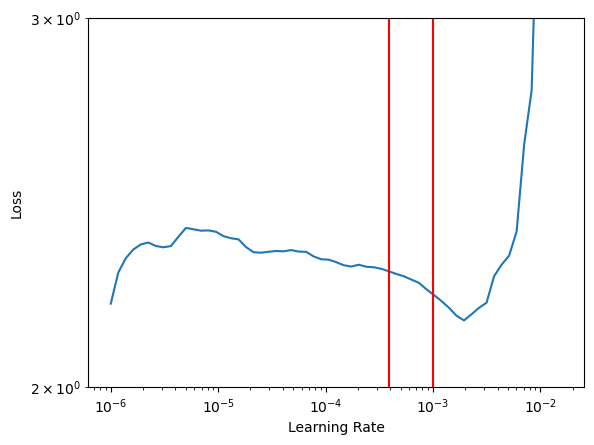

In [19]:
# Let's see if we can establish a reasoble range of learning rates so we can use cyclical learning rates when training
ax = finder.plot()
ax.set_yscale('log')

frac = 0.5 # This is how far "back" to move from the right-most red line to the "baseline" average of the first part of the curve

ax.set_ylim(2, 3)
for l_ in finder.estimate_clr(frac=frac):
    ax.axvline(l_, color='red')

<h3>Cyclical Learning Rates</h3>

Now, let's use cyclical learning rates to cycle between these bounds when training.  There are several different ways of doing this, outlined in the [original paper](https://arxiv.org/pdf/1506.01186), and we will explore them all here.

In [20]:
def fit_model(image_size, finder, n_classes, use_clr=False, wandb_project=None, mode='triangular'):
    """Convenient function to train models several times with different hyperparameters."""
    clr = utils.NNTools.CyclicalLearningRate(
        base_lr=finder.estimate_clr(frac=frac)[0],
        max_lr=finder.estimate_clr(frac=frac)[1],
        step_size=10, # 1/2 cycle every 10 epochs
        mode=mode,
    )

    # Build a fresh model
    model = make_model(image_size, n_classes=n_classes, activation='relu')

    # Build a data loader
    data_loader = utils.NNTools.build_loader('./1d-dataset/train', batch_size=100, shuffle=True)
    
    # Do the training
    model = utils.NNTools.train(
        model=model,
        data=data_loader, 
        fit_kwargs={
            'epochs': 60, # (10*2) = 20 epochs for a cycle, so this is 3 cycles
            'validation_data': utils.NNTools.build_loader('./1d-dataset/test', batch_size=100), # Shuffling doesn't matter here
            'callbacks': [clr] if use_clr else []
        },
        model_filename=None, # Do not save locally
        history_filename=None, # Do not save locally
        wandb_project=wandb_project,
        seed=42
    )
    
    return model, clr, data_loader

def plot_results(model, clr=None):
    """Convenient function to plot results locally - you can see the same results on WandB."""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

    for ax in axes:
        ax.set_xlabel('Epoch')
    
    if clr is not None:
        axes[0].plot(
            clr.history['iterations'],
            clr.history['lr']
        )
    else:
        axes[0].axhline(float(model.optimizer.lr))
    axes[0].set_ylabel('Learning Rate')
    axes[0].set_yscale('log')

    axes[1].plot(model.history.history['accuracy'], label='Accuracy')
    axes[1].plot(model.history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='best')

    axes[2].plot(model.history.history['loss'], label='Loss')
    axes[2].plot(model.history.history['val_loss'], label='Validation Loss')
    axes[2].set_ylabel('Loss')
    axes[2].legend(loc='best')

If you have not yet set up a [WandB](https://wandb.ai/) account, please do so or change the `wandb_project` below to `None`. After running the code below, visit wandb.com to look at the new runs stored in the 'cnn-1d-demo' project!

In [64]:
# Let's try several different CLR strategies to compare them.
model_none, _, dl_none = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=False, 
    wandb_project='cnn-1d-demo'
)

model_clr, clr, dl = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=True, 
    wandb_project='cnn-1d-demo', 
    mode='triangular'
)

model_clr2, clr2, dl2 = fit_model(
    image_size, 
    finder, 
    n_classes=n_classes, 
    use_clr=True, 
    wandb_project='cnn-1d-demo', 
    mode='triangular2'
)

In [22]:
# The same seed is given to Keras and same number of epochs are performed so data shuffling is the same
dl_none._XLoader__x[:3], dl._XLoader__x[:3], dl2._XLoader__x[:3]

(['/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000161.npy'],
 ['/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000094.npy',
  '/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000161.npy'],
 ['/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000121.npy',
  '/home/nam4/Documents/projects/active/2024-pgaa-imaging/code/pychemauth/docs/jupyter/api/1d-dataset/train/x_000000

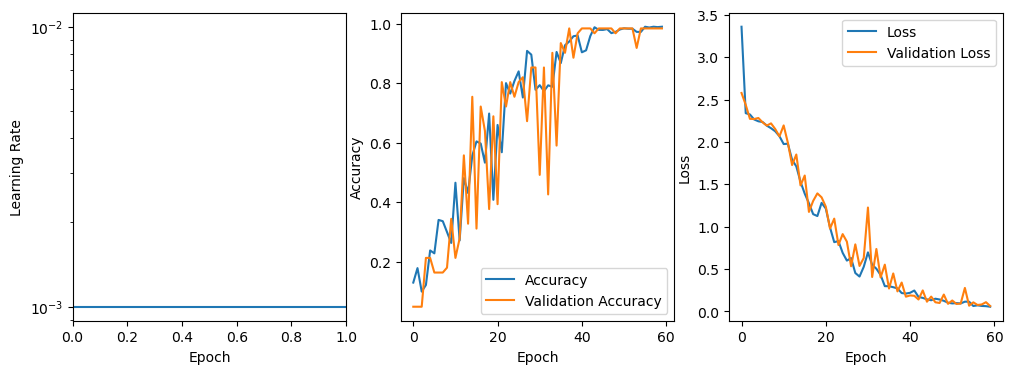

In [23]:
# We can also view the results here instead of on WandB
plot_results(model_none)

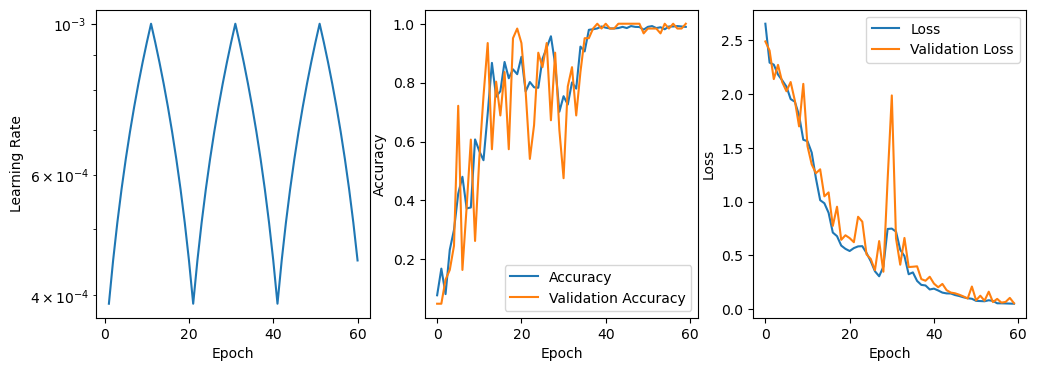

In [24]:
plot_results(model_clr, clr)

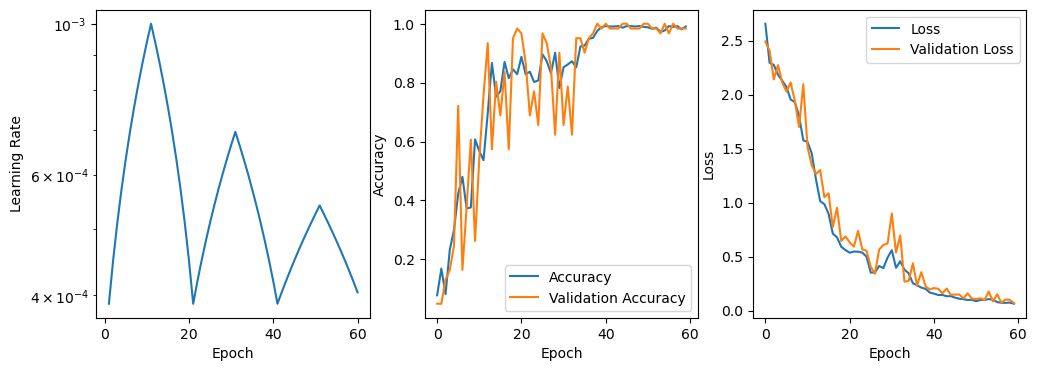

In [25]:
plot_results(model_clr2, clr2)

2D CNN
---

The 1D models above achieve essentially perfect accuracy on the valiation data.  Now let's try to build a 2D version.

<h3>Load Data</h3>

In [8]:
# Let's build 2D "images" of these spectra with the same preprocessing as above
res = make_pgaa_images(
    transformer=GramianAngularField(method='difference'), 
    exclude_classes=['Carbon Powder', 'Phosphate Rock', 'Zircaloy'], 
    directory='./2d-dataset', 
    overwrite=True, 
    fmt='npy', 
    valid_range=valid_range, 
    renormalize=True,
    test_size=0.2,
    random_state=42
)

Transforming test set: 100%|████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.54it/s]


In [9]:
# We will use the label encoder for nicer visualization later on
encoder = res[-1]

<h3>Learning Rate Finder</h3>

PyChemAuth comes with a `CNNFactory` to help automatically build 2D CNN models with pre-trained bases.  Visit [Keras Applications](https://keras.io/api/applications/) for a list of pre-trained bases available.  In the factory function below, you can invoke them using their (lowercase) name.

In [28]:
?CNNFactory

In [37]:
# Let's use the CNNFactory in PyChemAuth to build a model for transfer learning

image_size = (valid_range[1]-valid_range[0], valid_range[1]-valid_range[0], 1)
n_classes = 10

cnn_builder = CNNFactory(
    name='mobilenet', # Name of the "fixed" base we will use (trained on imagenet)
    input_size=image_size,
    n_classes=n_classes,
    pixel_range=(-1, 1),
    cam=True,
    dropout=0.2
) 

In [38]:
# Let's look at a basic summary of this model - note there are only ~10k trainable parameters but > 3M total!
model = cnn_builder.build()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 2631, 2631, 3)     3         
                                                                 
 rescaling (Rescaling)       (None, 2631, 2631, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 2631, 2631, 3)     0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 2631, 2631, 3)     0         
 da)                                                             
                                                                 
 mobilenet_1.00_224 (Functi  (None, 82, 82, 1024)      3228

/home/nam4/anaconda3/envs/pgaa-imaging/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


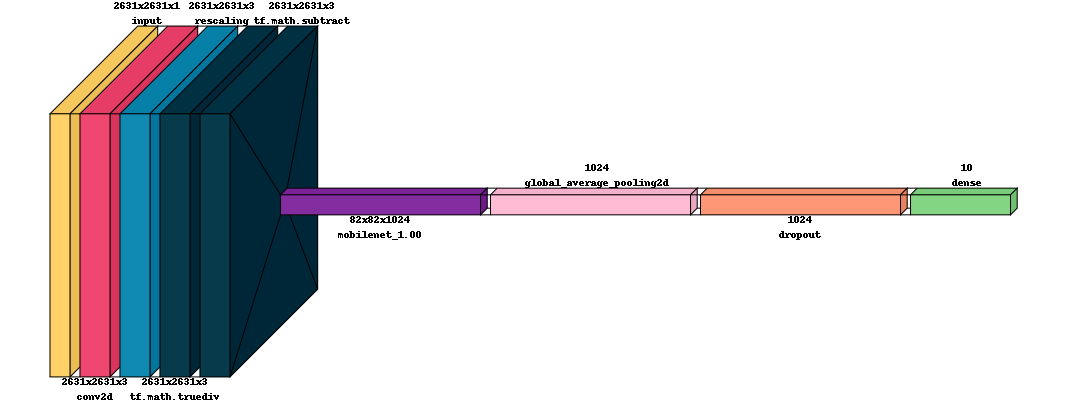

In [39]:
# We can also visualize the model another way
utils.NNTools.visualkeras(model, scale_xy=0.1, max_z=200)

In [63]:
# Now let's search for learning rate bounds
finder = utils.NNTools.find_learning_rate(
    cnn_builder.build(),
    pychemauth.utils.NNTools.build_loader('./2d-dataset/train/', batch_size=10),
    start_lr=1.0e-6,
)

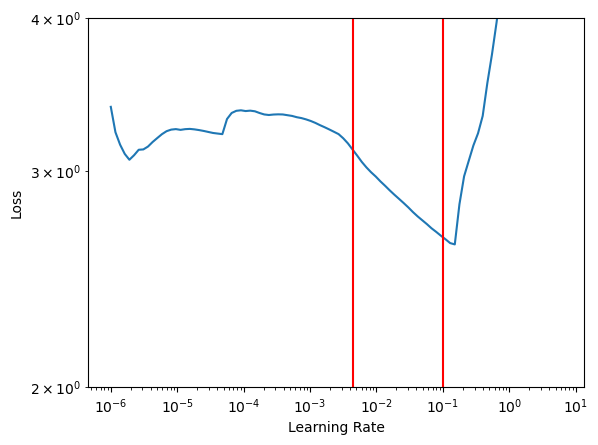

In [41]:
# "frac" can be adjusted to control the left / lower bound on the learning rate
# Adjust this until you are satisfied - we will use it next
frac = 0.9

ax = finder.plot()
ax.set_yscale('log')
ax.set_ylim(2,4)
for l_ in finder.estimate_clr(frac=frac):
    ax.axvline(l_, color='red')

<h3>Cyclical Learning Rates</h3>

Once again, let's train the model using cyclical learning rates.  

In [42]:
def fit_model(image_size, finder, use_clr=False, wandb_project=None, mode='triangular'):
    """Convenient function to train models several times with different hyperparameters."""
    clr = utils.NNTools.CyclicalLearningRate(
        base_lr=finder.estimate_clr(frac=frac)[0],
        max_lr=finder.estimate_clr(frac=frac)[1],
        step_size=10, # 1/2 cycle every 10 epochs
        mode=mode,
    )

    model = cnn_builder.build()

    data_loader = utils.NNTools.build_loader('./2d-dataset/train', batch_size=10, shuffle=True)
    
    model = utils.NNTools.train(
        model=model,
        data=data_loader, 
        fit_kwargs={
            'epochs': 60,
            'validation_data': utils.NNTools.build_loader('./2d-dataset/test', batch_size=10),
            'shuffle': True,
            'callbacks': [clr] if use_clr else []
        },
        model_filename=None,
        history_filename=None,
        wandb_project=wandb_project,
        seed=42
    )
    
    return model, clr, data_loader

In [62]:
# Fit the model and track the training on WandB
model, clr, dl = fit_model(
    image_size,
    finder,
    use_clr=True, 
    wandb_project='cnn-2d-demo',
    mode='triangular2'
)

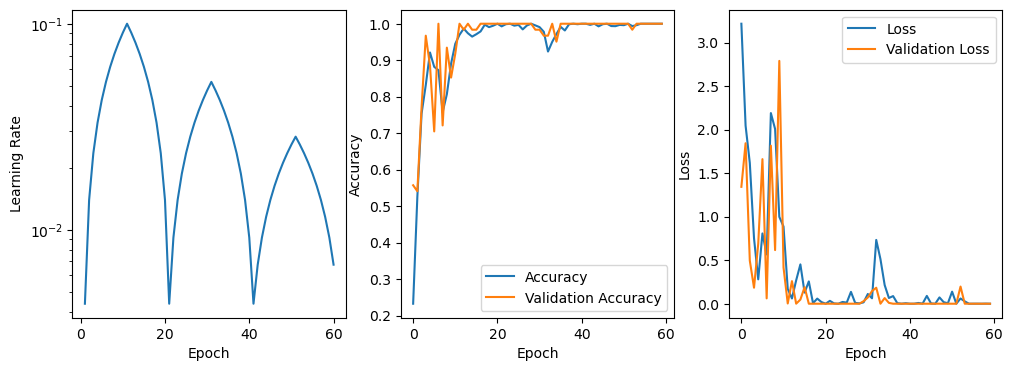

In [44]:
# Look at the results locally
plot_results(model, clr)

If you do not have a [HuggingFace Account](https://huggingface.co/) you can sign up for free.  Enter your API token to act as your login information as needed.  PyChemAuth contains the tools to automatically push and pull models from the registry as desired.  You can find more details and examples in [this notebook](https://pychemauth.readthedocs.io/en/latest/jupyter/api/sharing_models.html).

In [45]:
# Save the result to HuggingFace
_ = utils.HuggingFace.push_to_hub(
    model=model,
    namespace="mahynski", # Insert your own namespace here
    repo_name="2d-cnn-demo", # You can change the name if you like
    token="hf_*", # Insert your own token here
    private=False # This model is open to the public
)

model.pkl:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

In [46]:
# Load the model back from HuggingFace for comparison
hf_model = utils.HuggingFace.from_pretrained(
    model_id="mahynski/2d-cnn-demo",
)

model.pkl:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

In [47]:
# Confirm the models make the same predictions
preds = model.predict(utils.NNTools.build_loader('./2d-dataset/test', batch_size=10))
preds_hf = hf_model.predict(utils.NNTools.build_loader('./2d-dataset/test', batch_size=10))

np.allclose(preds, preds_hf)

7/7 [==============================] - 57s 8s/step


True

Explanations
---

It is often not enough to have an accurate model; we generally should have one that is also explainable so we can justify its predictions.  One way to explain CNN models is with [class activation maps](http://cnnlocalization.csail.mit.edu/) or CAMs.  Essentially, they highlight the parts of the images that are contributing to the model's opinion that an image belongs to the class it predicts.  They are not perfect and converns over their [method of calculation](https://arxiv.org/abs/2011.08891) and [misalignment](https://www.sciencedirect.com/science/article/pii/S0167865521003810#:~:text=There%20is%20a%20receptive%20field,adversarial%20marginal%20attack%20is%20proposed) of their [receptive fields](https://distill.pub/2019/computing-receptive-fields/) have been raised over the years, but CAMs are a popular tool nonetheless.

<h3>Class Activation Maps (CAMs)</h3>

In [48]:
# We can use a CAM explainer to visually explain each prediction
explainer = CAM2D(style='hires')

In [49]:
# Load 2D data (and 1D for visualization reasons)
data_loader_2d = utils.NNTools.build_loader('./2d-dataset/test', batch_size=10)
data_loader_1d = utils.NNTools.build_loader('./1d-dataset/test', batch_size=10)

In [50]:
def explain(batch_idx, idx_in_batch):
    """Explain predictions from a certain batch."""
    X_batch, y_batch = data_loader_2d[batch_idx]
    X, y = X_batch[idx_in_batch], y_batch[idx_in_batch]

    X_batch, y_batch = data_loader_1d[batch_idx]
    X_line, y_line = X_batch[idx_in_batch], y_batch[idx_in_batch]
    
    explainer.visualize(
        image=X,
        model=hf_model,
        y=X_line.ravel(),
        x=np.arange(X_line.shape[0]),
        correct_label=encoder.inverse_transform([y])[0],
        origin='upper',
        encoder=encoder
    )

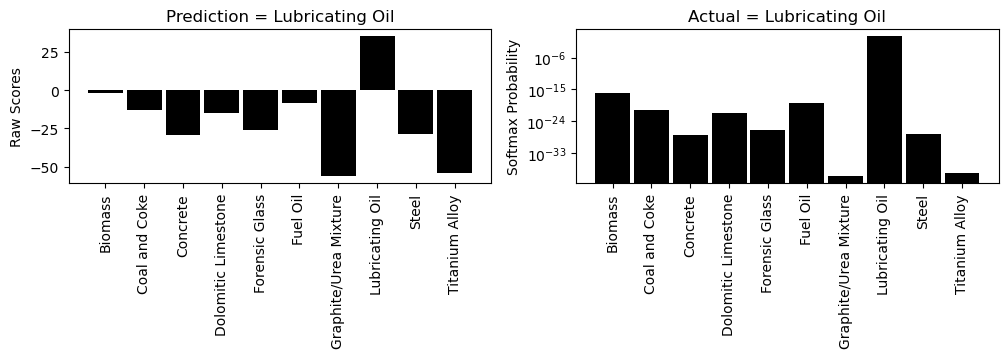

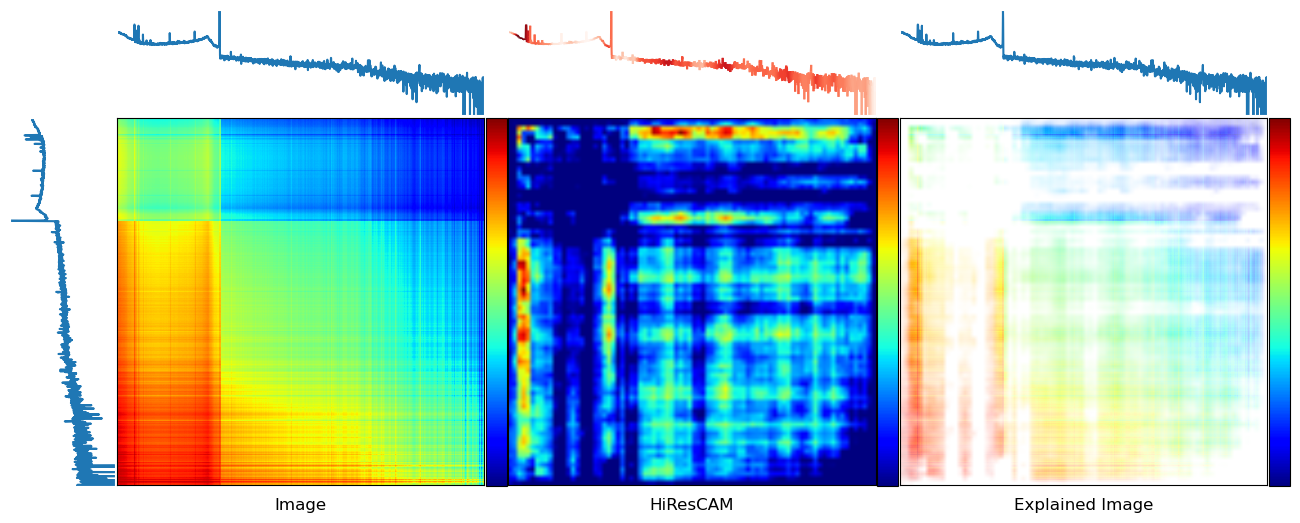

In [51]:
explain(0, 0)

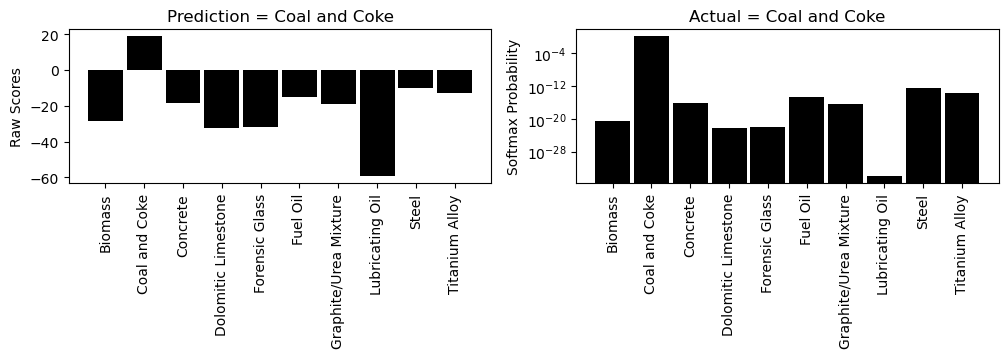

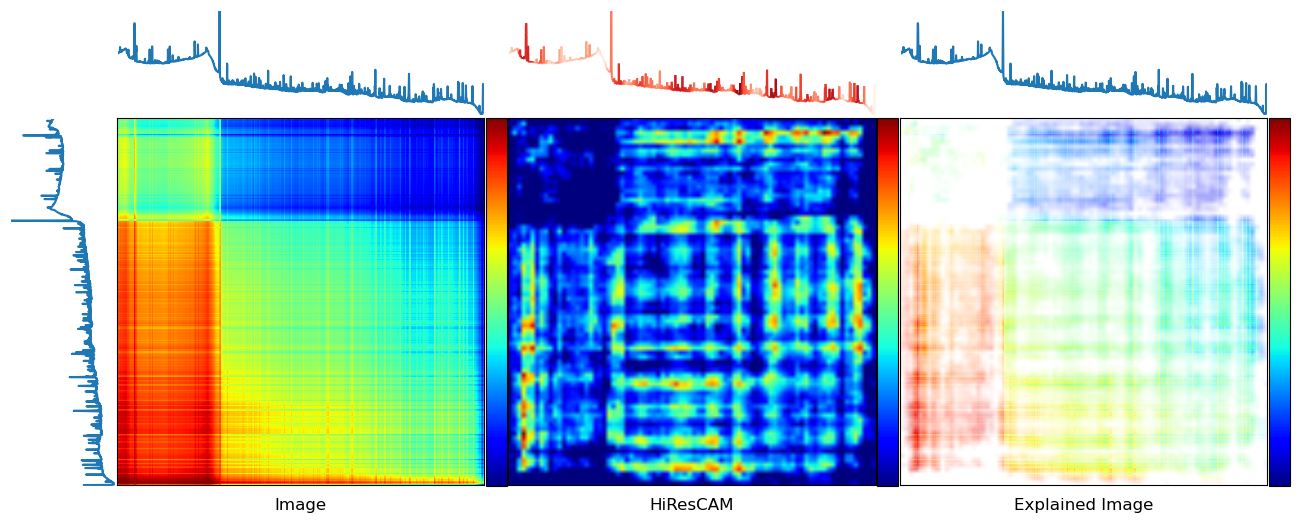

In [52]:
explain(0, 1)

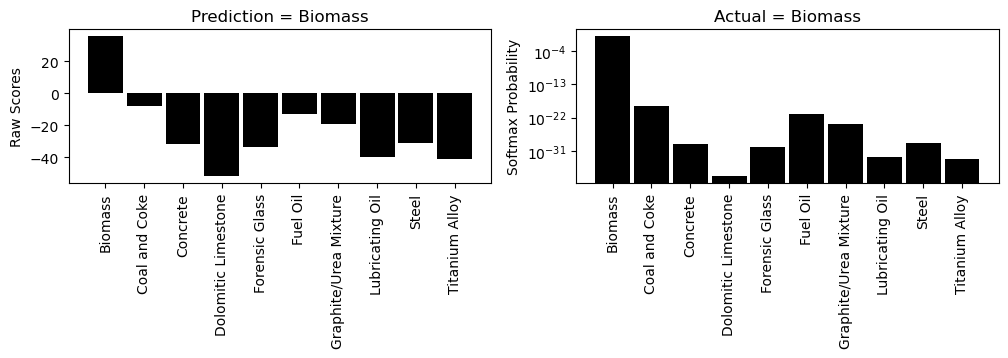

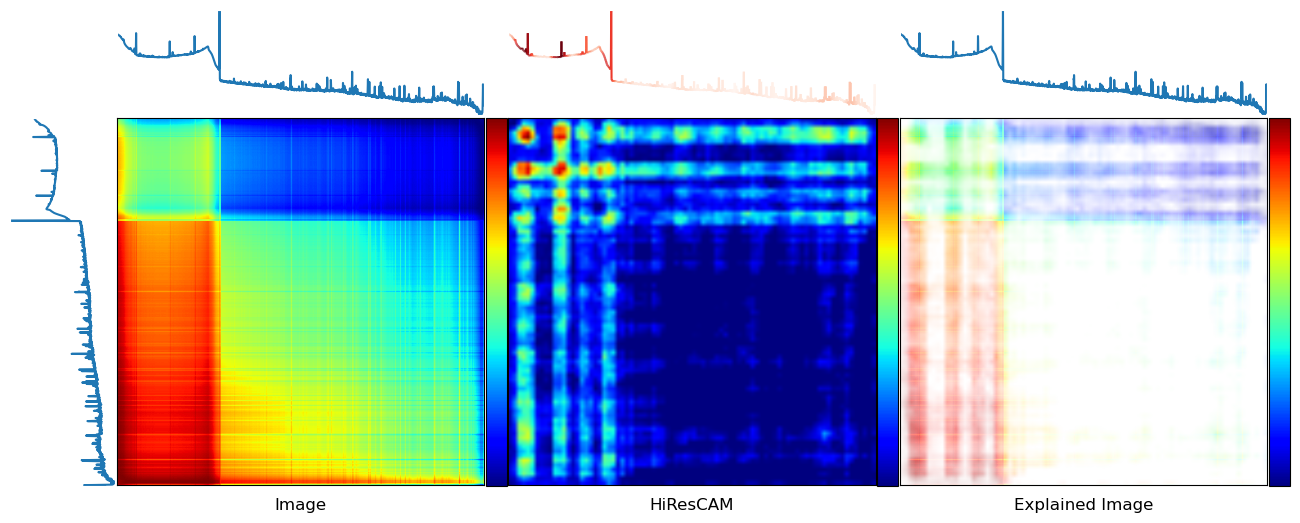

In [53]:
explain(0, 2)

<h3>Manual Inspection in 1D</h3>

Sometimes we might want to take a closer look and interactively explore an explanation, especially in 1D. Here is a way to do that using Bokeh for interactive visualization.

In [54]:
importances = explainer.importances(
    image=data_loader_2d[0][0][1],
    model=hf_model,
    symmetrize=True,
    dim=1, # Get a 1D summary of the 2D explanation
    series_summary='mean'
)

peaks = data_loader_1d[0][0][1]

In [55]:
from bokeh.io import output_notebook
output_notebook()

bokeh_color_spectrum(
    y=peaks,
    x=np.arange(peaks.shape[0]),
    importance_values=importances
)

Loading BokehJS ...

<h3>SHAP</h3>

Instead of CAM methods we can also use SHAP, just like with [other models](https://pychemauth.readthedocs.io/en/latest/jupyter/api/model_inspection.html). This explanation relies on the "partition" explainer by "blurring" pixels to create "super pixels".  See [here](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html) for more details on this methodology.

In [56]:
# Remember the model's properties - specifically, the "image" shape coming out of the pretrained CNN base
hf_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2631, 2631, 3)     3         
                                                                 
 rescaling_2 (Rescaling)     (None, 2631, 2631, 3)     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 2631, 2631, 3)     0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 2631, 2631, 3)     0         
 mbda)                                                           
                                                                 
 mobilenet_1.00_224 (Functi  (None, 82, 82, 1024)      3228

In [57]:
# Blur the input to about the same size as the output from the CNN base (here: (82, 82))
blur_size = hf_model.layers[-3].input_shape[1:3]

# Define a masker that is used to mask out partitions of the input image creating partitions.
# This is not strictly necessary (size can be arbitrary) but this way we can more fairly compare these
# explanations with those from CAM.
masker = shap.maskers.Image(f"blur{blur_size}", image_size)

# create an explainer with model and image masker
explainer = shap.Explainer(
    hf_model.predict,
    masker=masker, 
    output_names=encoder.classes_,
    algorithm="partition"
)

In [58]:
# Let's select the same points we did with CAM
X, y = data_loader_2d[0]

In [59]:
# The correct answers
encoder.inverse_transform(y[:3])

array(['Lubricating Oil', 'Coal and Coke', 'Biomass'], dtype=object)

In [67]:
# Explain these first 3 predictions - the "argsort" is a simple way to retrieve the top 4 most likely predictions.
# Conveniently, these are provided with SHAP.  Although we can compute similar CAM maps, this is not typically done
# and PyChemAuth is not configured for this at the moment.
shap_values = explainer(
    X[:3], 
    max_evals=500, # This controls how "fine-grained" the resulting map is
    outputs=shap.Explanation.argsort.flip[:4]
)

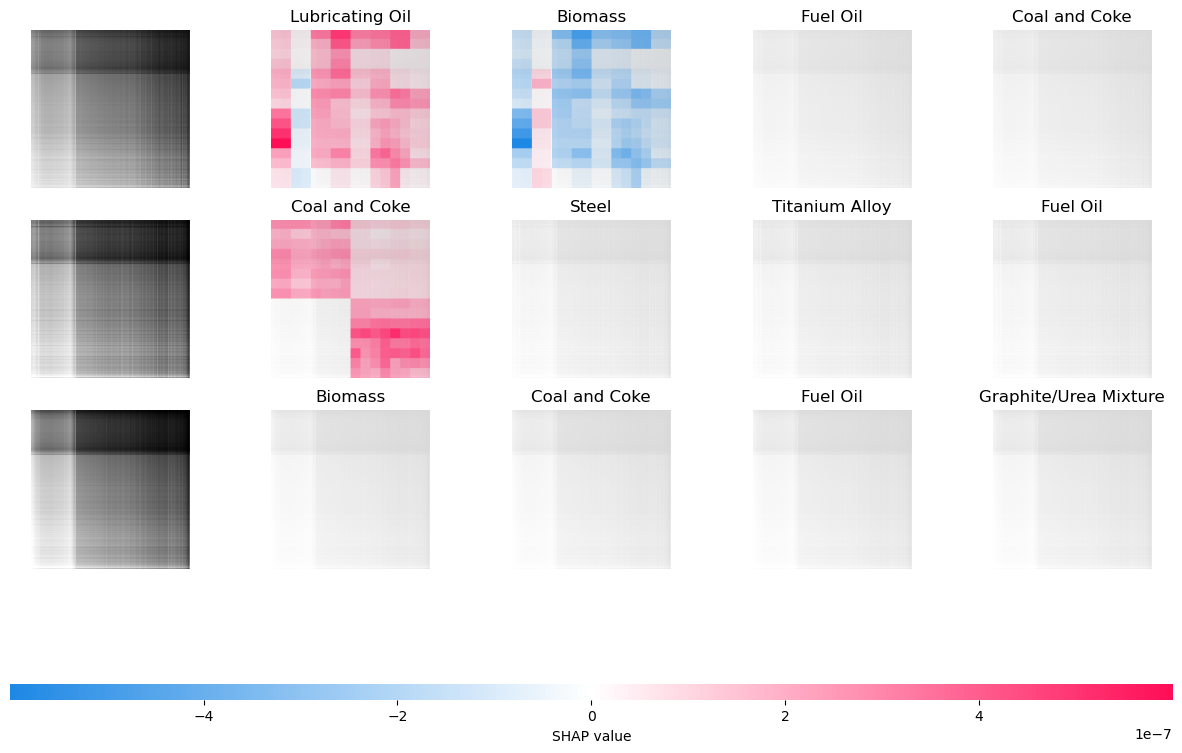

In [66]:
shap.image_plot(shap_values)

Out-of-Distribution (OOD) Detection
---

These tools are very good at differentiating between known classes.  However, in practice, such models must often be capable of recognizing when an input is OOD; that is, unlike what the model was trained on.  There are several OOD detectors that can be used, see the notebook on [Classification Under Open Set Conditions](https://pychemauth.readthedocs.io/en/latest/jupyter/api/opensetclassification.html) for more details.  Recall our 2D model architecture:

<img src="https://github.com/mahynski/pychemauth/blob/develop/docs/_static/cnn.png?raw=1" style="width:700px;">

Here, we will use [DIME](https://github.com/sartorius-research/dime.pytorch) to detect novel inputs by modeling the outputs of the CNN base after GAP.  That is, we examine the data at the leftmost gray arrow illustrated above.  DIME works as illustrated below (credit to the authors [here](https://github.com/sartorius-research/dime.pytorch)):

<img src="https://github.com/sartorius-research/dime.pytorch/blob/master/dime.png?raw=1" style="width:700px;">

Essentially, the CNN base featurizes the image producing a vector of certain length, $N$, after the GAP layer.  We can model this using truncated SVD to find a hyperplane these features fall in for the training set.  The distance to that hyperplane (or other distances) can be used to determine if a test point is OOD.  More details can be found in the original [paper](https://arxiv.org/abs/2108.10673).

In [10]:
def load_model():
    return utils.HuggingFace.from_pretrained(
        model_id="mahynski/2d-cnn-demo",
    )

In [11]:
load_model().summary() # In this example, the base is up to the last 2 layers (incl. GAP); the head is the final 2.

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2631, 2631, 3)     3         
                                                                 
 rescaling_2 (Rescaling)     (None, 2631, 2631, 3)     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 2631, 2631, 3)     0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 2631, 2631, 3)     0         
 mbda)                                                           
                                                                 
 mobilenet_1.00_224 (Functi  (None, 82, 82, 1024)      3228

In [12]:
def load_featurizer():
    m_ = load_model()
    return keras.Model(
        inputs=m_.layers[0].input, 
        outputs=m_.layers[-2].input # Here we are featurizing the data by using the model up to model.layers[-2]
    )

def load_head():
    m_ = load_model()
    return keras.Model(
        inputs=m_.layers[-2].input, # Here we are featurizing the data by using the model up to model.layers[-2]
        outputs=m_.layers[-1].output 
    )

<h3>Build the dataset</h3>

Here we will train a "compliant" model where certain known unknows are present in the training set.  This will affect model scoring and help the cross validation choose hyperparmeters (k) that help the DIME model distinguish betwen ID and OOD.

In [13]:
# Load the datasets containing classes [0, 9] 
d_train = utils.NNTools.build_loader('./2d-dataset/train', batch_size=10, shuffle=False)

X_train, y_train = [], []
for X_batch_, y_batch_ in d_train:
    X_train.append(X_batch_)
    y_train.append(y_batch_)
y_train = np.concatenate(y_train)
X_train = np.concatenate(X_train)

In [14]:
# Let's get the other classes in the dataset we did not train the model on
res_challenge = make_pgaa_images(
    transformer=GramianAngularField(method='difference'), 
    exclude_classes=encoder.classes_, # Exclude all the already known / trained on classes
    directory=None,
    fmt='npy', 
    valid_range=valid_range, 
    renormalize=True,
    test_size=0.0,
)

X_challenge, _, y_challenge, _, transformer_challenge, encoder_challenge = res_challenge

In [15]:
np.unique(y_challenge)

array([0, 1, 2])

In [16]:
known_classes = np.arange(0, 10)

In [17]:
# Map the y_challenge classes of [0, 1, 2] -> [10, 11, 12]
y_challenge += 10

In [18]:
# Split the challenge set (classes [10, 11, 12]) into test/train folds
Xc_train, Xc_test, yc_train, yc_test = sklearn.model_selection.train_test_split(
    X_challenge, y_challenge, test_size=0.2, stratify=y_challenge, random_state=42, shuffle=True
)

# Append the data with these "known unknowns"
X_train = np.vstack((X_train, Xc_train))
y_train = np.concatenate((y_train, yc_train))

In [19]:
def build_classifier(featurized=False, updated_kwargs={}):
    kwargs = { # Baseline kwargs for OSR
        'clf_prefit':True,
        'known_classes':known_classes,
        'inlier_value':True,
        'unknown_class':-1,
        'score_metric':'TEFF',
        'clf_style':'hard',
        'score_using':'all'
    }
        
    outlier_kwargs = {
        'model': None if featurized else load_featurizer(),
        'alpha': 0.05,
        'k': 20
    }
    outlier_kwargs.update(updated_kwargs)
    
    kwargs.update({
        'clf_model': osr.DeepOOD.DIMEFeatureClf(
            model_loader=load_model, 
            input_layer=-2  # If featurized, the data was transformed up to the second to last layer, only need to finish
        ) if featurized else load_model(),
        'outlier_model': osr.DeepOOD.DIME,
        'outlier_kwargs': outlier_kwargs,
    })
        
    return osr.OpenSetClassifier(**kwargs)

<h3>Building the OOD Detector</h3>

In [20]:
# Let's just look at DIME as an OOD detector using some default hyperparameters
model = build_classifier(featurized=False)
_ = model.fit(X_train, y_train)

2024-09-23 15:46:46.719235: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14187364352 exceeds 10% of free system memory.
2024-09-23 15:46:48.187771: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14208933888 exceeds 10% of free system memory.


1/8 [==>...........................] - ETA: 3:17

2024-09-23 15:47:13.052594: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14187364352 exceeds 10% of free system memory.
2024-09-23 15:47:14.478470: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14208933888 exceeds 10% of free system memory.


2/8 [======>.......................] - ETA: 2:41

2024-09-23 15:47:40.127264: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14187364352 exceeds 10% of free system memory.


8/8 [==============================] - 207s 26s/step


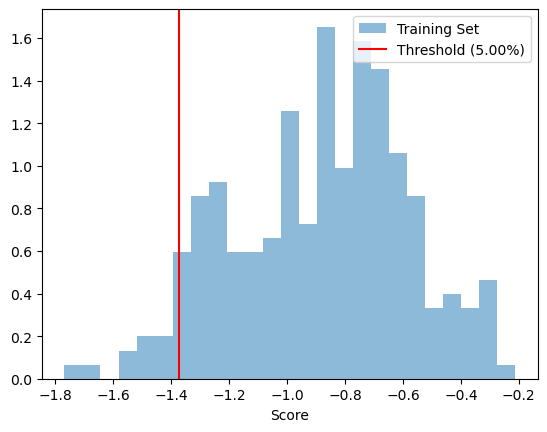

In [21]:
# This is the training set alone (only ID points / knowns - excludes known unknowns)
_ = model.fitted_outlier_model.visualize()

1/1 [==============================] - 19s 19s/step


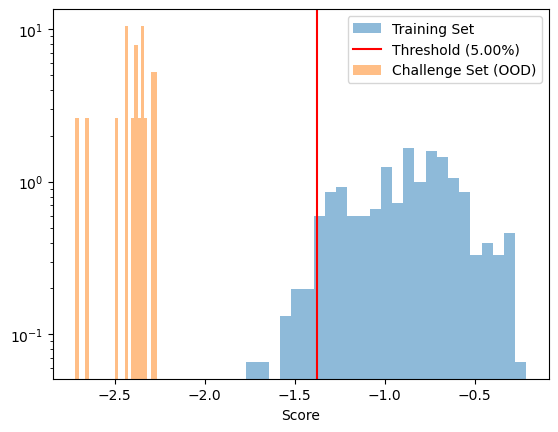

In [22]:
# Clearly the challenge set is well separated from the training set
ax = model.fitted_outlier_model.visualize(
    X_test=X_challenge, 
    test_label='Challenge Set (OOD)', 
    bins=25
)
ax.set_yscale('log')

<h3>Building an OSR Model with a Pretrained Classifier</h3>

In [20]:
# For DIME OOD we are going to cut off the CNN after the GAP layer
X_feature = load_featurizer().predict(X_train)

2024-09-23 16:02:23.540573: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14187364352 exceeds 10% of free system memory.
2024-09-23 16:02:25.010301: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14208933888 exceeds 10% of free system memory.


1/9 [==>...........................] - ETA: 3:39

2024-09-23 16:02:48.654806: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14187364352 exceeds 10% of free system memory.
2024-09-23 16:02:50.080501: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14208933888 exceeds 10% of free system memory.


2/9 [=====>........................] - ETA: 2:58

2024-09-23 16:03:14.208322: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14187364352 exceeds 10% of free system memory.


9/9 [==============================] - 211s 23s/step


In [28]:
# Optimize hyperparameters using featurized dataset for speed
pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("osr", build_classifier(featurized=True))
    ]
)

param_grid = [{
    'osr__outlier_kwargs': [{'model':None, 'alpha':a, 'k':k} for a in np.logspace(-3, np.log10(0.5), 10) for k in [1, 5, 10, 20, 50]],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_feature, y_train)

optimal_hyperparameters = copy.copy(gs.best_params_['osr__outlier_kwargs'])
optimal_hyperparameters.pop('model')

In [22]:
optimal_hyperparameters

{'alpha': 0.001, 'k': 20}

In [23]:
# Build a final pipeline with these hyperparameters that can accept the original input
final_pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("osr", build_classifier(featurized=False, updated_kwargs=optimal_hyperparameters))
    ]
)

final_pipeline.fit(X_train, y_train)

8/8 [==============================] - 227s 28s/step


Pipeline(steps=[('osr',
                 OpenSetClassifier(clf_model=<keras.src.engine.functional.Functional object at 0x79971bfbbdd0>,
                                   clf_prefit=True, inlier_value=True,
                                   known_classes=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                   outlier_kwargs={'alpha': 0.001, 'k': 20,
                                                   'model': <keras.src.engine.functional.Functional object at 0x799607a30a10>},
                                   outlier_model=<class 'pychemauth.classifier.osr.DeepOOD.DIME'>,
                                   unknown_class=-1))])

In [24]:
# Build the test set include some known unknowns
d_test = utils.NNTools.build_loader('./2d-dataset/test', batch_size=10, shuffle=False)

X_test, y_test = [], []
for X_batch_, y_batch_ in d_test:
    X_test.append(X_batch_)
    y_test.append(y_batch_)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

X_test = np.vstack((X_test, Xc_test))
y_test = np.concatenate((y_test, yc_test))

In [25]:
fom_test = final_pipeline.named_steps['osr'].figures_of_merit(final_pipeline.predict(X_test), y_test)

2/2 [==============================] - 54s 25s/step


In [26]:
# Perfect performance on the test set!
fom_test['CM']

,0,1,2,3,4,5,6,7,8,9,-1
0,5,0,0,0,0,0,0,0,0,0,1
1,0,19,0,0,0,0,0,0,0,0,0
2,0,0,8,0,0,0,0,0,0,0,0
3,0,0,0,3,0,0,0,0,0,0,0
4,0,0,0,0,4,0,0,0,0,0,0
5,0,0,0,0,0,5,0,0,0,0,0
6,0,0,0,0,0,0,3,0,0,0,0
7,0,0,0,0,0,0,0,8,0,0,0
8,0,0,0,0,0,0,0,0,3,0,0
9,0,0,0,0,0,0,0,0,0,2,0


1/1 [==============================] - 20s 20s/step


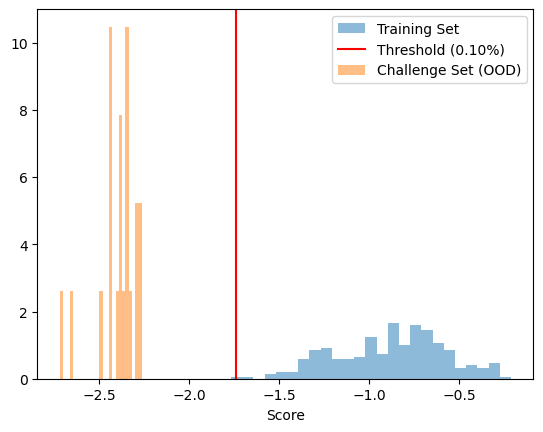

In [27]:
_ = final_pipeline.named_steps['osr'].fitted_outlier_model.visualize(
    X_test=X_challenge, 
    test_label='Challenge Set (OOD)', 
    bins=25
)